In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/Multiclass_Labelled_Dataset'
os.chdir(project_path)

In [3]:
!ls

aggregated_data.csv		   GosungLight2_Multi.csv   phillipsHub_Multi.csv
aggregated_data_with_Label.csv	   kasaSmartPlug_Multi.csv  RingDoorbell_Multi.csv
amazonAlexa_Multi.csv		   longPlus-Cam_Multi.csv   roborockVacc_Multi.csv
combined_data_without_okpVacc.csv  nestCam_Multi.csv	    session_data.csv
googleNestMini_Multi.csv	   okpVacc_Multi.csv	    sliding_windows_data.csv


In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Multiclass_Labelled_Dataset/combined_data_without_okpVacc.csv')

In [6]:
data.head()

,Unnamed: 0,device_id,session_id,src_ip,dst_ip,src_port,dst_port,protocol,timestamp,flow_duration,...,fwd_blk_rate_avg,bwd_blk_rate_avg,fwd_seg_size_avg,bwd_seg_size_avg,cwr_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,Label
0,0,1,192.168.1.215-255.255.255.255-49154-6667-17,192.168.1.215,255.255.255.255,49154,6667,17,14-08-2024 8:00,120013552,...,0.0,0.0,230.000000,0.0,0,22,0,5060,0,Benign
1,1,1,192.168.1.192-131.100.0.205-50458-5938-6,192.168.1.192,131.100.0.205,50458,5938,6,14-08-2024 8:00,110128079,...,0.0,0.0,81.000000,75.0,0,8,8,648,600,Benign
2,2,1,192.168.1.102-255.255.255.255-9487-9478-17,192.168.1.102,255.255.255.255,9487,9478,17,14-08-2024 8:00,120012804,...,0.0,0.0,82.000000,0.0,0,2,0,164,0,Benign
3,3,1,192.168.1.102-224.0.0.251-5353-5353-17,192.168.1.102,224.0.0.251,5353,5353,17,14-08-2024 8:01,101790420,...,0.0,0.0,177.357143,0.0,0,14,0,2483,0,Benign
4,4,1,192.168.1.243-255.255.255.255-5683-5683-17,192.168.1.243,255.255.255.255,5683,5683,17,14-08-2024 8:01,125747851,...,0.0,0.0,139.000000,0.0,0,7,0,973,0,Benign


In [7]:
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
drop_columns = [
    "id"
   ]
data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

In [9]:
print(data['timestamp'].isnull().sum())
print(data['timestamp'].head())

0
0   2024-08-14 08:00:00
1   2024-08-14 08:00:00
2   2024-08-14 08:00:00
3   2024-08-14 08:01:00
4   2024-08-14 08:01:00
Name: timestamp, dtype: datetime64[ns]


In [10]:
# Define window size and step size
window_size = pd.Timedelta('1m')  # 1 minute window
step_size = pd.Timedelta('30s')   # 30-second sliding step

In [11]:

data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

# Aggregate session-based features, direction-based features and timestamp information
session_data = data.groupby(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']).agg(
    # Session-based aggregations
    flow_duration=('flow_duration', 'sum'),
    total_forward_packets=('tot_fwd_pkts', 'sum'),
    total_backward_packets=('tot_bwd_pkts', 'sum'),
    total_bytes_forward=('totlen_fwd_pkts', 'sum'),
    total_bytes_backward=('totlen_bwd_pkts', 'sum'),
    mean_packet_length_forward=('fwd_pkt_len_mean', 'mean'),
    mean_packet_length_backward=('bwd_pkt_len_mean', 'mean'),
    packet_size_mean=('pkt_len_mean', 'mean'),
    flow_iat_mean=('flow_iat_mean', 'mean'),
    down_up_ratio=('down_up_ratio', 'mean'),
    subflow_fwd_pkts=('subflow_fwd_pkts', 'sum'),
    subflow_bwd_pkts=('subflow_bwd_pkts', 'sum'),
    subflow_fwd_byts=('subflow_fwd_byts', 'sum'),
    subflow_bwd_byts=('subflow_bwd_byts', 'sum'),

    # Direction-specific aggregations (Forward flows)
    fwd_pkt_len_mean=('fwd_pkt_len_mean', 'mean'),
    fwd_pkt_len_max=('fwd_pkt_len_max', 'max'),
    fwd_pkt_len_min=('fwd_pkt_len_min', 'min'),
    fwd_pkt_len_std=('fwd_pkt_len_std', 'std'),
    fwd_iat_mean=('fwd_iat_mean', 'mean'),
    fwd_iat_max=('fwd_iat_max', 'max'),
    fwd_iat_min=('fwd_iat_min', 'min'),
    fwd_iat_tot=('fwd_iat_tot', 'sum'),
    fwd_blk_rate_avg=('fwd_blk_rate_avg', 'mean'),

    # Direction-specific aggregations (Backward flows)
    bwd_pkt_len_mean=('bwd_pkt_len_mean', 'mean'),
    bwd_pkt_len_max=('bwd_pkt_len_max', 'max'),
    bwd_pkt_len_min=('bwd_pkt_len_min', 'min'),
    bwd_pkt_len_std=('bwd_pkt_len_std', 'std'),
    bwd_iat_mean=('bwd_iat_mean', 'mean'),
    bwd_iat_max=('bwd_iat_max', 'max'),
    bwd_iat_min=('bwd_iat_min', 'min'),
    bwd_iat_tot=('bwd_iat_tot', 'sum'),
    bwd_blk_rate_avg=('bwd_blk_rate_avg', 'mean'),

    # Total packets and bytes
    total_packets=('tot_fwd_pkts', lambda x: x.sum() + data['tot_bwd_pkts'].sum()),
    total_bytes=('totlen_fwd_pkts', lambda x: x.sum() + data['totlen_bwd_pkts'].sum()),

    # Timestamp info: min and max timestamp per session
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
).reset_index()

In [12]:
session_data.to_csv('/content/drive/MyDrive/Multiclass_Labelled_Dataset/session_data.csv')

In [13]:
session_data.head()

,src_ip,dst_ip,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes,start_time,end_time
0,0.0.0.0,255.255.255.255,68,67,17,704649549,84,0,28558,0,...,0.0,0.0,0,0,0,0.0,255140,255625043,2024-08-13 08:01:00,2024-08-16 13:28:00
1,13.107.246.41,192.168.1.192,443,50272,6,10256,4,3,303,210,...,NaN,2448.5,3921,976,4897,0.0,255060,255596788,2024-08-13 08:00:00,2024-08-13 08:00:00
2,13.107.42.18,192.168.1.192,443,33066,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,255057,255596539,2024-08-16 08:05:00,2024-08-16 08:05:00
3,13.107.42.18,192.168.1.192,443,36978,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,255057,255596539,2024-08-15 07:02:00,2024-08-15 07:02:00
4,13.107.42.18,192.168.1.192,443,45660,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,255057,255596539,2024-08-14 08:32:00,2024-08-14 08:32:00


In [14]:
# Time-Based Sliding Window Aggregation
def sliding_window_aggregation(data, window_size, step_size):
    window_aggregates = []

    # Generate the start times using pd.date_range
    start_times = pd.date_range(start=data.index.min(), end=data.index.max(), freq=step_size)

    # Iterate over each time window
    for start_time in start_times:
        end_time = start_time + window_size
        window = data[(data.index >= start_time) & (data.index < end_time)]

        # Perform aggregation for each window
        aggregated = {
            'start_time': start_time,
            'end_time': end_time,
            'total_forward_packets_window': window['tot_fwd_pkts'].sum(),
            'total_backward_packets_window': window['tot_bwd_pkts'].sum(),
            'total_forward_bytes_window': window['totlen_fwd_pkts'].sum(),
            'total_backward_bytes_window': window['totlen_bwd_pkts'].sum(),
            'average_packet_size_fwd_window': window['fwd_pkt_len_mean'].mean(),
            'average_packet_size_bwd_window': window['bwd_pkt_len_mean'].mean(),
            'flow_duration_window': window['flow_duration'].sum(),
            'packet_count_window': len(window)  # Count of packets in the window
        }

        window_aggregates.append(aggregated)

    return pd.DataFrame(window_aggregates)

In [15]:
# Set the timestamp as the index for resampling
data.set_index('timestamp', inplace=True)

In [16]:
# Apply sliding window aggregation
sliding_windows_data = sliding_window_aggregation(data, window_size, step_size)

In [17]:
sliding_windows_data.to_csv('/content/drive/MyDrive/Multiclass_Labelled_Dataset/sliding_windows_data.csv')

In [18]:
sliding_windows_data.head()

,start_time,end_time,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window
0,2024-08-13 08:00:00,2024-08-13 08:01:00,261,158,28218,11769,64.239935,56.293254,1370937322,126
1,2024-08-13 08:00:30,2024-08-13 08:01:30,42,9,6232,671,134.525210,8.519608,208424228,17
2,2024-08-13 08:01:00,2024-08-13 08:02:00,42,9,6232,671,134.525210,8.519608,208424228,17
3,2024-08-13 08:01:30,2024-08-13 08:02:30,92,6,15528,492,127.553571,5.125000,460103011,16
4,2024-08-13 08:02:00,2024-08-13 08:03:00,92,6,15528,492,127.553571,5.125000,460103011,16


In [19]:
# Merge sliding window and session data on overlapping time intervals
aggregated_data = pd.merge_asof(
    sliding_windows_data.sort_values('start_time'),
    session_data.sort_values('start_time'),
    left_on='start_time',
    right_on='start_time',
    direction='backward'
)

In [20]:
aggregated_data.to_csv('/content/drive/MyDrive/Multiclass_Labelled_Dataset/aggregated_data.csv')

In [21]:
aggregated_data.head()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes,end_time_y
0,2024-08-13 08:00:00,2024-08-13 08:01:00,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,60,NaN,0.0,0,0,0,0.0,255057,255596539,2024-08-13 08:00:00
1,2024-08-13 08:00:30,2024-08-13 08:01:30,42,9,6232,671,134.525210,8.519608,208424228,17,...,60,NaN,0.0,0,0,0,0.0,255057,255596539,2024-08-13 08:00:00
2,2024-08-13 08:01:00,2024-08-13 08:02:00,42,9,6232,671,134.525210,8.519608,208424228,17,...,0,0.0,0.0,0,0,0,0.0,274591,258853885,2024-08-16 15:59:00
3,2024-08-13 08:01:30,2024-08-13 08:02:30,92,6,15528,492,127.553571,5.125000,460103011,16,...,0,0.0,0.0,0,0,0,0.0,274591,258853885,2024-08-16 15:59:00
4,2024-08-13 08:02:00,2024-08-13 08:03:00,92,6,15528,492,127.553571,5.125000,460103011,16,...,0,0.0,0.0,0,0,0,0.0,255061,255597090,2024-08-16 13:51:00


In [22]:
# Select columns (src_ip, dst_ip, and Label) from the original DataFrame
original_dataset = data[['src_ip', 'dst_ip', 'Label']].drop_duplicates()

In [23]:
# merge
aggregated_data = aggregated_data.merge(original_dataset, on=['src_ip', 'dst_ip'], how='left')

In [24]:
print(aggregated_data.head())

           start_time          end_time_x  total_forward_packets_window  \
0 2024-08-13 08:00:00 2024-08-13 08:01:00                           261   
1 2024-08-13 08:00:00 2024-08-13 08:01:00                           261   
2 2024-08-13 08:00:00 2024-08-13 08:01:00                           261   
3 2024-08-13 08:00:00 2024-08-13 08:01:00                           261   
4 2024-08-13 08:00:00 2024-08-13 08:01:00                           261   

   total_backward_packets_window  total_forward_bytes_window  \
0                            158                       28218   
1                            158                       28218   
2                            158                       28218   
3                            158                       28218   
4                            158                       28218   

   total_backward_bytes_window  average_packet_size_fwd_window  \
0                        11769                       64.239935   
1                        11769  

In [25]:
aggregated_data.to_csv('/content/drive/MyDrive/Multiclass_Labelled_Dataset/aggregated_data_with_Label.csv')

In [26]:
num_rows = aggregated_data.shape[0]
print(f"Number of rows in aggregated_data: {num_rows}")

Number of rows in aggregated_data: 10583


In [27]:
# Temporal features
# Calculate the time difference
aggregated_data['time_diff'] = aggregated_data['end_time_x'] - aggregated_data['start_time']

In [28]:
# convert to seconds
aggregated_data['time_diff_seconds'] = aggregated_data['time_diff'].dt.total_seconds()

In [29]:
print(aggregated_data[['start_time', 'end_time_x', 'time_diff', 'time_diff_seconds']])

               start_time          end_time_x       time_diff  \
0     2024-08-13 08:00:00 2024-08-13 08:01:00 0 days 00:01:00   
1     2024-08-13 08:00:00 2024-08-13 08:01:00 0 days 00:01:00   
2     2024-08-13 08:00:00 2024-08-13 08:01:00 0 days 00:01:00   
3     2024-08-13 08:00:00 2024-08-13 08:01:00 0 days 00:01:00   
4     2024-08-13 08:00:00 2024-08-13 08:01:00 0 days 00:01:00   
...                   ...                 ...             ...   
10578 2024-08-16 15:58:00 2024-08-16 15:59:00 0 days 00:01:00   
10579 2024-08-16 15:58:30 2024-08-16 15:59:30 0 days 00:01:00   
10580 2024-08-16 15:59:00 2024-08-16 16:00:00 0 days 00:01:00   
10581 2024-08-16 15:59:30 2024-08-16 16:00:30 0 days 00:01:00   
10582 2024-08-16 16:00:00 2024-08-16 16:01:00 0 days 00:01:00   

       time_diff_seconds  
0                   60.0  
1                   60.0  
2                   60.0  
3                   60.0  
4                   60.0  
...                  ...  
10578               60.0  
105

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

Multi-Class Classification

In [31]:
# Multi-class Classification

X = aggregated_data.drop(columns=['Label'])  # Drop target and non-feature columns
y = aggregated_data['Label']

In [32]:
# Creating a new column BinLabel
aggregated_data['BinLabel'] = aggregated_data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [33]:
# selecting numeric attributes columns from aggregated_data
num_col = list(aggregated_data.select_dtypes(include='number').columns)
num_col.remove('BinLabel')
print(num_col)

['total_forward_packets_window', 'total_backward_packets_window', 'total_forward_bytes_window', 'total_backward_bytes_window', 'average_packet_size_fwd_window', 'average_packet_size_bwd_window', 'flow_duration_window', 'packet_count_window', 'src_port', 'dst_port', 'protocol', 'flow_duration', 'total_forward_packets', 'total_backward_packets', 'total_bytes_forward', 'total_bytes_backward', 'mean_packet_length_forward', 'mean_packet_length_backward', 'packet_size_mean', 'flow_iat_mean', 'down_up_ratio', 'subflow_fwd_pkts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_bwd_byts', 'fwd_pkt_len_mean', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_iat_mean', 'fwd_iat_max', 'fwd_iat_min', 'fwd_iat_tot', 'fwd_blk_rate_avg', 'bwd_pkt_len_mean', 'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_iat_mean', 'bwd_iat_max', 'bwd_iat_min', 'bwd_iat_tot', 'bwd_blk_rate_avg', 'total_packets', 'total_bytes', 'time_diff', 'time_diff_seconds']


In [34]:
# Checking for infinity or NaN values and replacing them with the median value of the column
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in num_col:
    if aggregated_data[col].isnull().sum() > 0:
        median_value = aggregated_data[col].median()
        aggregated_data[col] = aggregated_data[col].fillna(median_value)

In [35]:
X = aggregated_data.drop(columns=['Label', 'src_ip', 'dst_ip', 'start_time', 'end_time_x', 'end_time_y', 'time_diff', 'BinLabel'])  # Drop target and non-feature columns
y = aggregated_data['Label']

In [36]:
# Preprocess the data (Scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
print(X_scaled[0])

[ 3.44007894e-01  5.03673028e-02  2.22844098e-02 -1.84585076e-02
 -1.97535204e+00  2.38209395e+00  6.06002387e+00  4.18534844e+00
 -1.88820013e-01 -2.17336389e+00 -3.38387178e+00 -1.40303386e-02
 -2.40850752e-02 -1.08665297e-03 -2.55007412e-02 -1.69254287e-02
 -1.22300079e+00  1.17493874e+00 -1.05804821e+00 -2.52175438e-02
  3.40267250e+00 -2.40850752e-02 -1.08665297e-03 -2.55007412e-02
 -1.69254287e-02 -1.22300079e+00 -6.44032630e-01 -1.31111015e+00
 -1.80634469e-02 -2.42124235e-02 -3.32316165e-02 -4.41077635e-02
 -1.38153304e-02 -2.29027241e-02  1.17493874e+00  2.86924206e-01
  2.28247675e+00 -1.95789726e-02 -5.87273294e-02 -5.17522436e-02
 -4.74332652e-02 -2.57784250e-02 -1.46644929e-02 -2.40850752e-02
 -2.55007412e-02  0.00000000e+00]


In [38]:
# Feature Engineering
#  Apply PCA for dimensionality reduction

n_components = 18
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

In [39]:
# Explained Variance
print(pca.explained_variance_ratio_)

[0.2767263  0.1453717  0.13814324 0.12722816 0.06080716 0.04078356
 0.03482932 0.0322506  0.03145217 0.02118591 0.01624642 0.01538324
 0.01410953 0.01028329 0.0091415  0.00789867 0.00678175 0.00313119]


In [40]:
# PCA Data
expl_var = pca.explained_variance_ratio_
df_expl_var = pd.DataFrame(
    data=zip(range(1, len(expl_var) + 1), expl_var, expl_var.cumsum()),
    columns=['PCA', 'Explained Variance (%)', 'Total Explained Variance (%)']
    ).set_index('PCA').mul(100).round(1)
print(df_expl_var)

     Explained Variance (%)  Total Explained Variance (%)
PCA                                                      
1                      27.7                          27.7
2                      14.5                          42.2
3                      13.8                          56.0
4                      12.7                          68.7
5                       6.1                          74.8
6                       4.1                          78.9
7                       3.5                          82.4
8                       3.2                          85.6
9                       3.1                          88.8
10                      2.1                          90.9
11                      1.6                          92.5
12                      1.5                          94.0
13                      1.4                          95.5
14                      1.0                          96.5
15                      0.9                          97.4
16            

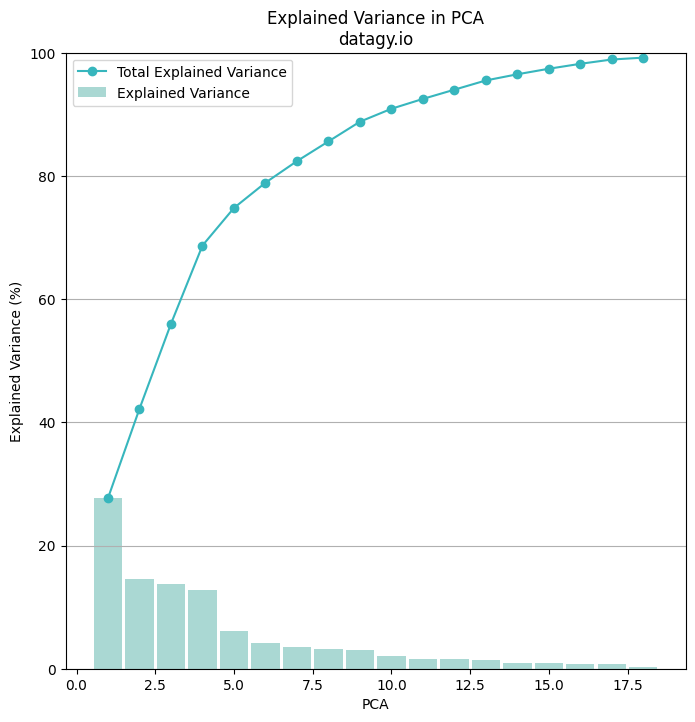

In [41]:
# Plotting PCA
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=df_expl_var.index, height=df_expl_var['Explained Variance (%)'], label='Explained Variance', width=0.9, color='#AAD8D3')
ax.plot(df_expl_var['Total Explained Variance (%)'], label='Total Explained Variance', marker='o', c='#37B6BD')

plt.ylim(0, 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('PCA')
plt.grid(True, axis='y')
plt.title('Explained Variance in PCA\ndatagy.io')
plt.legend()

In [42]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [43]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [44]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [45]:
# One-hot encoded format for model training
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [46]:
# Verification
print("Original Labels:", y_train[:5])
print("Encoded Labels:", y_train_encoded[:5])
print("One-hot Encoded Labels:\n", y_train_categorical[:5])

Original Labels: 2034                      Benign
7075                      Benign
2856    UDPAttack_googleNestMini
9173                      Benign
5412                      Benign
Name: Label, dtype: object
Encoded Labels: [ 0  0 24  0  0]
One-hot Encoded Labels:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [47]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Model Building
model = Sequential([
    Input(shape=(n_components,)),  # Input layer with PCA features
    Dense(64, activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(y_train_categorical.shape[1], activation='softmax')  # Output layer
])

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# Train the model
history = model.fit(X_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test, y_test_categorical))

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8078 - loss: 1.5846 - val_accuracy: 0.8857 - val_loss: 0.4280
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8812 - loss: 0.4434 - val_accuracy: 0.8860 - val_loss: 0.4101
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8891 - loss: 0.3995 - val_accuracy: 0.8872 - val_loss: 0.4037
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8821 - loss: 0.4148 - val_accuracy: 0.8882 - val_loss: 0.3962
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8873 - loss: 0.3822 - val_accuracy: 0.8876 - val_loss: 0.3891
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8951 - loss: 0.3601 - val_accuracy: 0.8872 - val_loss: 0.3870
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - loss: 0.3641 - val_accuracy: 0.8891 - val_loss: 0.3866
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8903 - loss: 0.3672 - val_accuracy: 0

In [50]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8911 - loss: 0.3832
Test Loss: 0.3715061843395233, Test Accuracy: 0.8875590562820435


In [51]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_prob = model.predict(X_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [52]:
#  Convert to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

In [53]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[2787    0    0 ...    3    1    0]
 [   0    3    0 ...    1    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    1    0    0]
 [   0    0    0 ...    2    2    0]
 [   0    0    0 ...    1    0    0]]


In [54]:
#  Precision, Recall, F1-score (with zero_division to handle undefined metrics)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2815
           1       0.14      0.27      0.18        11
           2       1.00      0.00      0.00         8
           3       1.00      0.00      0.00         3
           4       1.00      0.00      0.00         5
           5       0.00      0.00      1.00        14
           6       1.00      0.00      0.00         5
           7       0.00      0.00      1.00        12
           8       1.00      0.00      0.00        13
           9       0.03      0.33      0.05         6
          10       0.17      0.08      0.11        13
          11       1.00      0.00      0.00         5
          12       1.00      0.00      0.00         5
          13       0.12      0.50      0.20         2
          14       0.18      0.31      0.23        13
          15       1.00      0.00      0.00         6
          16       0.04      0.08      0.05        13
   

In [55]:
# Model Fine-tuning

from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer with regularization
    Dropout(0.3),  # Another Dropout
    Dense(32, activation='relu'),  # Another hidden layer
    Dense(y_train_categorical.shape[1], activation='softmax')  # Output layer for multi-class classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
X_train, X_val, y_train_categorical, y_val = train_test_split(X_train, y_train_categorical, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train_categorical,
                    epochs=50, batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7347 - loss: 1.6234 - val_accuracy: 0.8799 - val_loss: 0.4496
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8829 - loss: 0.4505 - val_accuracy: 0.8725 - val_loss: 0.4457
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8805 - loss: 0.4290 - val_accuracy: 0.8799 - val_loss: 0.4334
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8838 - loss: 0.4154 - val_accuracy: 0.8819 - val_loss: 0.4291
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8823 - loss: 0.4237 - val_accuracy: 0.8765 - val_loss: 0.4217
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8853 - loss: 0.4081 - val_accuracy: 0.8772 - val_loss: 0.4115
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8877 - loss: 0.3877 - val_accuracy: 0.8839 - val_loss: 0.4044
Epoch 8/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8888 - loss: 0.3907 - val_accuracy: 0

In [58]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8857 - loss: 0.3670
Test Loss: 0.35878807306289673, Test Accuracy: 0.8872441053390503


In [59]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
 [[2778    0    3 ...    4    1    0]
 [   1    4    0 ...    1    0    0]
 [   2    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    1    0    0]
 [   0    0    0 ...    1    0    0]
 [   0    0    0 ...    1    1    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2815
           1       0.13      0.36      0.19        11
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00        12
           8       0.00      0.00      0.00        13
           9       0.04      0.50      0.07         6
          10       0.25      0.15      0.19        13
          11       0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
# Batch Normalization

from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

In [61]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
X_train, X_val, y_train_categorical, y_val = train_test_split(X_train, y_train_categorical, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5145 - loss: 2.8098 - val_accuracy: 0.8895 - val_loss: 1.3532
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8751 - loss: 0.8692 - val_accuracy: 0.8954 - val_loss: 0.5507
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8838 - loss: 0.5625 - val_accuracy: 0.8938 - val_loss: 0.4730
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8925 - loss: 0.4652 - val_accuracy: 0.8954 - val_loss: 0.4626
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8941 - loss: 0.4069 - val_accuracy: 0.8954 - val_loss: 0.4156
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8791 - loss: 0.4428 - val_accuracy: 0.8954 - val_loss: 0.3925
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8943 - loss: 0.3704 - val_accuracy: 0.8954 - val_loss: 0.3923
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8915 - loss: 0.3839 - val_accuracy: 0

In [63]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8914 - loss: 0.3889
Test Loss: 0.38059577345848083, Test Accuracy: 0.8897637724876404


In [64]:
# Batch Normalization

from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(y_train_categorical.shape[1], activation='softmax')
])

In [65]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)
model.fit(X_train, y_train_categorical, validation_data=(X_val, y_val), callbacks=[lr_reduction])

149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5314 - loss: 2.6979 - val_accuracy: 0.8862 - val_loss: 0.9366 - learning_rate: 0.0010


In [67]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
for train_idx, val_idx in kfold.split(X_train):
    model.fit(X_train[train_idx], y_train_categorical[train_idx], validation_data=(X_train[val_idx], y_train_categorical[val_idx]))

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8701 - loss: 0.8953 - val_accuracy: 0.8924 - val_loss: 0.5851
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.5975 - val_accuracy: 0.8819 - val_loss: 0.4639
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8865 - loss: 0.4808 - val_accuracy: 0.8787 - val_loss: 0.4952
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8891 - loss: 0.4368 - val_accuracy: 0.8892 - val_loss: 0.4167
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8882 - loss: 0.4339 - val_accuracy: 0.8755 - val_loss: 0.4987


# Binary Classification


In [68]:
# Binary Classification
X = aggregated_data.drop(columns=['BinLabel', 'Label', 'src_ip', 'dst_ip',  'start_time', 'end_time_x', 'end_time_y', 'time_diff'])
y = aggregated_data['BinLabel']

In [69]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# Model Building
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),  # Dropout layer for regularization
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.3),  # Dropout layer for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [71]:
# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
print(X.dtypes)

total_forward_packets_window        int64
total_backward_packets_window       int64
total_forward_bytes_window          int64
total_backward_bytes_window         int64
average_packet_size_fwd_window    float64
average_packet_size_bwd_window    float64
flow_duration_window                int64
packet_count_window                 int64
src_port                            int64
dst_port                            int64
protocol                            int64
flow_duration                       int64
total_forward_packets               int64
total_backward_packets              int64
total_bytes_forward                 int64
total_bytes_backward                int64
mean_packet_length_forward        float64
mean_packet_length_backward       float64
packet_size_mean                  float64
flow_iat_mean                     float64
down_up_ratio                     float64
subflow_fwd_pkts                    int64
subflow_bwd_pkts                    int64
subflow_fwd_byts                  

In [73]:
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9142 - loss: 0.3073 - val_accuracy: 0.9835 - val_loss: 0.0394
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9853 - loss: 0.0503 - val_accuracy: 0.9876 - val_loss: 0.0320
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9851 - loss: 0.0457 - val_accuracy: 0.9858 - val_loss: 0.0308
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0331 - val_accuracy: 0.9888 - val_loss: 0.0304
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9899 - loss: 0.0375 - val_accuracy: 0.9906 - val_loss: 0.0299
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9908 - loss: 0.0273 - val_accuracy: 0.9882 - val_loss: 0.0296
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9903 - loss: 0.0341 - val_accuracy: 0.9888 - val_loss: 0.0296
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0312 - val_accuracy: 0

In [74]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9840 - loss: 0.0377
Test Loss: 0.04119164124131203, Test Accuracy: 0.9867737293243408


In [75]:
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [76]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1860   24]
 [   4  229]]


In [77]:
# Precision, Recall, and F1-Score
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1884
           1       0.91      0.98      0.94       233

    accuracy                           0.99      2117
   macro avg       0.95      0.99      0.97      2117
weighted avg       0.99      0.99      0.99      2117

